## Language Translator

In [1]:
import nltk

From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [2]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to /home/jewelle/nltk_data...
[nltk_data]   Package comtrans is already up-to-date!


True

In [3]:
from nltk.corpus import comtrans
print(comtrans.aligned_sents('alignment-en-fr.txt')[0])

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [4]:
len(comtrans.aligned_sents('alignment-en-fr.txt'))

33334

### Actually building a translator

In [5]:
import warnings
warnings.filterwarnings('ignore')

import string
import re
from numpy import array, argmax, random, take
from numpy.random import rand, shuffle
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from unicodedata import normalize
from tensorflow.keras.preprocessing.text import Tokenizer
from konoha import WordTokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

from pickle import dump
from pickle import load

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10285000692917845906
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17578154472098912852
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16682677706235892000
physical_device_desc: "device: XLA_GPU device"
]


In [9]:
path = '/home/jewelle/data_bootcamp/w9/mini-project-V/'

data = read_text(path + 'fra.txt') #dataset from Ballad of Edgardo

In [10]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [106]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [107]:
es_en = to_lines(data)
es_en = array(es_en)

In [108]:
es_en

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.',
        'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)'],
       ['Since there are usually multiple websites on any given to

### Cleaning

In [109]:
# Remove punctuation
es_en[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in es_en[:,0]]
es_en[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in es_en[:,1]]

# convert text to lowercase
for i in range(len(es_en)):
    es_en[i,0] = es_en[i,0].lower()
    es_en[i,1] = es_en[i,1].lower()

In [110]:
es_en

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate change',
        'una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)'],
       ['since there are usually multiple websites on any given topic i usua

In [11]:
#split into sentence pairs

def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [12]:
# clean line by line
def clean_pairs(lines):
    cleaned = list()
    
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
    
    for line in pair:
        # normalize unicode characters
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # tokenize on white space
        line = line.split()
        # convert to lowercase
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [word.translate(table) for word in line]
        # remove non-printable chars form each token
        line = [re_print.sub('', w) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
    return array(cleaned)

In [13]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [14]:
# load dataset
filename = 'fra.txt'
doc = read_text(filename)

# split into english-other lang sentence pairs
pairs = to_pairs(doc)

# extensive clean sentences
clean_pairs = clean_pairs(pairs)

In [15]:
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

[if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker] => [si quelquun qui ne connait pas vos antecedents dit que vous parlez comme un locuteur natif cela veut dire quil a probablement remarque quelque chose a propos de votre elocution qui lui a fait prendre conscience que vous netes pas un locuteur natif en dautres termes vous ne parlez pas vraiment comme un locuteur natif]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [17]:
# save clean data to file
save_clean_data(clean_pairs, 'fra_en_raw.pkl')

Saved: fra_en_raw.pkl


In [18]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# load dataset
data = load_clean_sentences('fra_en_raw.pkl')
 
# reduce dataset size
n = 10000
dataset = data[:n, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = data[:9000], data[9000:]
# save
save_clean_data(data, 'combined-data.pkl')
save_clean_data(train, 'fra-en-train.pkl')
save_clean_data(test, 'fra-en-test.pkl')

Saved: combined-data.pkl
Saved: fra-en-train.pkl
Saved: fra-en-test.pkl


### Tokenize

In [19]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
def ja_tokenization(lines):
    ja_tokenizer = WordTokenizer('MeCab')
    ja_tokenizer.fit_on_texts(lines)
    return ja_tokenizer

In [21]:
#function for finding maximum length of sentence
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [22]:
# english tokenizer
eng_tokenizer = tokenization(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 33
English Max Length: 44


In [23]:
# prepare other language tokenizer
fr_tokenizer = tokenization(dataset[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1
fr_length = max_length(dataset[:, 0])

print('French Vocabulary Size: %d' % fr_vocab_size)
print('French Max Length: %d' % (fr_length))

French Vocabulary Size: 39
French Max Length: 44


In [24]:
# encode and pad sequences to max length
def encode_sequences(tokenizer, length, lines):
        sequence = tokenizer.texts_to_sequences(lines)
        # pad sequences with 0 values
        sequence = pad_sequences(sequence, maxlen=length, padding='post')
        return sequence

In [25]:
# split data into train and test set
train, test = train_test_split(dataset, test_size=0.2, random_state = 12)

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [336]:
# prepare training data
X_train = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [337]:
# prepare test data
X_test = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

### LSTM Model

In [312]:
#import packages

In [354]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [367]:
# model compilation
model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 256)

In [380]:
#RMS is good optimizer for RNNs
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.mini_project_v'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/10
 9/13 [===================>..........] - ETA: 2:40 - loss: 1.2689ETA: 1:51 - loss: 1.271

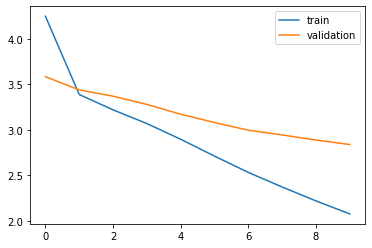

In [370]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [371]:
model = load_model('model.mini_project_v')
preds = model.predict_classes(X_test.reshape((X_test.shape[0],X_test.shape[1])))

In [372]:
#function to return array to words
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [376]:
#init predictions
preds_text = []

for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None): 
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [377]:
pred = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [378]:
pred.head()

,actual,predicted
0,whats this,he tom
1,marry me,they be me
2,is this correct,is was my
3,please listen,please sit
4,he bit his lip,he is the


In [301]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

OSError: Please set MECAB_CHARSET before running the tests

In [303]:
import helper
import collections

# Load English data
en_sentences = read_text(path +'en_small.txt')
# Load French data
fr_sentences = read_text(path +'fr_small.txt')

In [297]:
for sample_i in range(2):
    print('en Line {}:  {}'.format(sample_i + 1, en_sentences[sample_i]))
    print('fr Line {}:  {}'.format(sample_i + 1, fr_sentences[sample_i]))

en Line 1:  n
fr Line 1:  n
en Line 2:  e
fr Line 2:  e


In [298]:
english_words_counter = collections.Counter([word for sentence in en_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in fr_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in en_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in fr_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

7261975 English words.
30 unique English words.
10 Most common words in the English dataset:
"i" "e" "s" "t" "r" "a" "n" "u" "l" "d"

7885766 French words.
39 unique French words.
10 Most common words in the French dataset:
"e" "s" "a" "i" "t" "l" "n" "r" "m" "o"


In [299]:
def tokenize(x):

    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [300]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

NameError: name 'tests' is not defined